# **Maestría en Inteligencia Artificial Aplicada**

## **Proyecto Integrador - TC5035**

## Semana 4: Avance 3 - Baseline

### Profesores
- Dra. Grettel Barceló Alonso
- Dr. Luis Eduardo Falcón Morales

### Asesor
- Dr. Gerardo Jesús Camacho González

### Patrocinadores
- Dr. Jorge Antonio Ascencio Gutiérrez
- Yanmei King Loeza

### Equipo 29
- Carolina Lucas Dophe  –  A01702450
- Juan Pablo López Sánchez   –   A01313663
- Víctor Hugo Soto Herrera   –   A01706446

### Fecha de entrega
Domingo 15 de febrero de 2026

### Tabla de contenido
[Introducción](#intro)

1. [Carga de librerías y configuración inicial](#config)
2. [Preparación final de datos](#preparacion)
3. [Modelo baseline y evaluación de métricas](#baseline)
4. [Intepretación y comparación](#interpretacion)

[Conclusiones](#conclusiones)

[Referencias](#ref)

### <a class="anchor" id="intro">Introducción</a>

En este avance se construye un modelo de referencia (baseline) con el propósito de evaluar la viabilidad del problema de predicción de la oferta productiva de aguacate en el estado de Jalisco, a partir del conjunto de datos preparado en las etapas anteriores de análisis exploratorio e ingeniería de características.

El objetivo principal de este baseline no es maximizar el desempeño predictivo, sino establecer un punto de comparación mínimo que permita determinar si las variables disponibles contienen señal suficiente para explicar el comportamiento del volumen de producción. Un desempeño comparable al azar indicaría limitaciones estructurales en los datos o en el planteamiento del problema, mientras que un desempeño razonable validaría la pertinencia de avanzar hacia modelos más complejos.

Asimismo, el baseline cumple una función práctica en la gestión de expectativas del proyecto, al proporcionar una referencia clara sobre lo que puede lograrse con métodos simples y altamente interpretables antes de invertir esfuerzos adicionales en técnicas avanzadas de modelado. Este enfoque es consistente con una metodología CRISP-ML, en la que cada etapa valida supuestos clave antes de escalar la complejidad del análisis.

### <a class="anchor" id="config">1. Carga de librerías y configuración inicial</a>

En esta sección se cargan las librerías necesarias para el manejo, limpieza, integración y exploración de los datos, así como algunas configuraciones básicas para facilitar la visualización y el análisis posterior.

In [55]:
# Cargar librerías
import io
import numpy as np
import pandas as pd

from pathlib import Path
from sklearn.impute import SimpleImputer

import ipywidgets as widgets
from IPython.display import display, HTML

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from statsmodels.tsa.arima.model import ARIMA

from sklearn.metrics import root_mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error

In [2]:
# Configuración de visualización
pd.set_option("display.max_columns", None)
pd.set_option("display.float_format", "{:,.2f}".format)


def output_info(output, title, info, label=None, clear=True):
    if clear:
        output.clear_output()
    label_text = f"{label}: " if label is not None else ""

    # Detectar tipo de info
    if isinstance(info, pd.Series):
        info_html = "<br>".join(
            f"{idx}: {val}" for idx, val in info.items()
        )
    elif isinstance(info, pd.DataFrame):
        info_html = info.to_html()
    elif isinstance(info, str):
        info_html = f"<pre style='font-size: 13px'>{info}</pre>"
    else:
        info_html = str(info)

    with output:
        display(HTML(f"""
            <style>
                .output-title {{
                    font-size: 20px;
                    font-weight: 600;
                    margin: 8px 0px;
                }}
                .output-subtitle {{
                    font-size: 17px;
                    font-weight: 600;
                    margin: 8px 0px;
                }}
                .output-text {{
                    font-size: 15px;
                }}
            </style>
            <div class="output-title">{title}</div>
            <div class="output-subtitle">{label_text}</div>
            <div class="output-text">{info_html}</div>
        """))


def get_df_info(df):
    buffer = io.StringIO()
    df.info(buf=buffer)
    return buffer.getvalue()

In [4]:
# Definición de rutas base
DATA_DIR = Path("data")
RAW_DATA_DIR = DATA_DIR / "raw"
PROCESSED_DATA_DIR = DATA_DIR / "processed"

# Definición de rutas de archivos generado en Avance 2
X_FILE = PROCESSED_DATA_DIR / "X_final_mensual.csv"
y_FILE = PROCESSED_DATA_DIR / "y_mensual.csv"

### <a class="anchor" id="preparacion">2. Carga y preparación final de datos</a>

En esta sección se cargan los conjuntos de datos finales de características (X) y variable objetivo (y), generados durante la etapa de preparación e ingeniería de características del Avance 2. Estos archivos representan el insumo definitivo para la construcción del modelo de referencia (baseline), por lo que no se realizan transformaciones estructurales adicionales, sino únicamente ajustes necesarios para garantizar compatibilidad con los algoritmos de modelado.

Dado que algunos algoritmos de aprendizaje supervisado no admiten valores faltantes de forma nativa, se aplica un proceso de imputación simple sobre las variables explicativas, con el objetivo de asegurar un entrenamiento estable y reproducible. Esta imputación se realiza exclusivamente sobre el conjunto de características y no sobre la variable objetivo, preservando así la integridad del problema de regresión.

#### 2.1 Revisión estructural de los conjuntos de datos

Se realiza una inspección general de la estructura de los conjuntos de datos generados en la entrega anterior.

In [5]:
# Carga de datasets finales
X = pd.read_csv(X_FILE)
y = pd.read_csv(y_FILE)

In [6]:
# Dos columnas
X_head_output = widgets.Output(layout=widgets.Layout(width='50%'))
y_head_output = widgets.Output(layout=widgets.Layout(width='50%'))
label="Muestra de datos"

# Visualización de dimensiones de los datasets
output_info(X_head_output, "Conjunto de características (X)", X.head(), label)
output_info(y_head_output, "Conjunto objetivo (y)", y.head(), label)
display(widgets.HBox([X_head_output, y_head_output]))

In [7]:
# Dos columnas
X_shape_output = widgets.Output(layout=widgets.Layout(width='50%'))
y_shape_output = widgets.Output(layout=widgets.Layout(width='50%'))
label="Dimensiones"

# Visualización de dimensiones de los datasets
output_info(X_shape_output, "Conjunto de características (X)", X.shape, label)
output_info(y_shape_output, "Conjunto objetivo (y)", y.shape, label)
display(widgets.HBox([X_shape_output, y_shape_output]))

In [8]:
# Dos columnas
X_desc_output = widgets.Output(layout=widgets.Layout(width='50%'))
y_desc_output = widgets.Output(layout=widgets.Layout(width='50%'))
label="Estadísticas Descriptivas"

# Descripción de los datasets
output_info(X_desc_output, "Conjunto de características (X)", X.describe().T, label)
output_info(y_desc_output, "Conjunto objetivo (y)", y.describe().T, label)
display(widgets.HBox([X_desc_output, y_desc_output]))

In [9]:
# Dos columnas
X_info_output = widgets.Output(layout=widgets.Layout(width='50%'))
y_info_output = widgets.Output(layout=widgets.Layout(width='50%'))
label="Información General"

# Visualización de dimensiones de los datasets
output_info(X_info_output, "Conjunto de características (X)", get_df_info(X), label)
output_info(y_info_output, "Conjunto objetivo (y)", get_df_info(y), label)
display(widgets.HBox([X_info_output, y_info_output]))

In [10]:
# Dos columnas
X_na_output = widgets.Output(layout=widgets.Layout(width='50%'))
y_na_output = widgets.Output(layout=widgets.Layout(width='50%'))
label="Valores Faltantes"

# Revisión de valores faltantes
output_info(X_na_output, "Conjunto de características (X)", X.isna().sum(), label)
output_info(y_na_output, "Conjunto objetivo (y)", y.isna().sum(), label)
display(widgets.HBox([X_na_output, y_na_output]))

#### 2.2 Imputación de valores faltantes

Dado que la proporción de valores faltantes es reducida y se concentra en variables categóricas previamente codificadas, se opta por una imputación mediante la mediana, una estrategia robusta frente a valores extremos y adecuada para variables numéricas continuas.

Este paso se realiza antes de la separación en conjuntos de entrenamiento y prueba, con el fin de mantener consistencia en el tratamiento de los datos y facilitar la reproducibilidad del ejercicio de baseline.

In [11]:
# Imputación por mediana
imputer = SimpleImputer(strategy="median")

X_imputed = pd.DataFrame(
    imputer.fit_transform(X),
    columns=X.columns
)

# Verificación posterior a la imputación
X_imputed_na_output = widgets.Output(layout=widgets.Layout(width='50%'))

# Revisión de valores faltantes
output_info(X_imputed_na_output, "Conjunto de características (X)", X_imputed.isna().sum(), label="Valores Faltantes")
display(widgets.HBox([X_imputed_na_output]))

In [12]:
# Asegurar alineación entre 'X_imputed' y 'y'
assert X_imputed.shape[0] == y.shape[0], "'X_imputed' y 'y' no están alineados"

**Consideraciones para el modelado**

El conjunto `X_imputed` será utilizado como entrada para los modelos de referencia en las siguientes secciones. Las transformaciones más complejas (escalamiento, regularización y selección de hiperparámetros) se abordarán de forma explícita en cada modelo, de acuerdo con sus supuestos y requerimientos específicos.

#### 2.3 Particionamiento de conjuntos de entrenamiento y pruebas

Dado que el problema aborda la predicción del volumen de producción en una serie temporal, la partición de los datos se realiza utilizando un criterio cronológico y no mediante el método tradicional de `train_test_split` aleatorio. En problemas con estructura temporal, una división aleatoria puede introducir información futura dentro del conjunto de entrenamiento, generando estimaciones optimistas y poco realistas del desempeño del modelo.

Por esta razón, el conjunto de entrenamiento se conforma con las observaciones más antiguas, mientras que el conjunto de prueba contiene los periodos más recientes. Esta estrategia permite simular un escenario práctico de predicción hacia el futuro y evaluar la capacidad real de generalización del modelo baseline.

In [13]:
# Ordenar por tiempo (aunque ya debería estarlo)
X_imputed = X_imputed.sort_index()
y = y.sort_index()

split_idx = int(len(X_imputed) * 0.8)

X_train = X_imputed.iloc[:split_idx]
X_test  = X_imputed.iloc[split_idx:]

y_train = y.iloc[:split_idx]
y_test  = y.iloc[split_idx:]

El conjunto de datos se dividió en subconjuntos de entrenamiento y prueba utilizando un criterio temporal, con el fin de simular un escenario realista de predicción hacia el futuro. Esta partición será utilizada de forma consistente en todos los modelos evaluados en este avance.

#### 2.4 Validaciones

**`NOTA`**: El particionamiento temporal del conjunto de datos se definió en una etapa previa del proyecto, utilizando las variables originales de año y mes. En este notebook se trabaja directamente con las matrices de características ya transformadas y escaladas, por lo que no es posible reconstruir explícitamente la línea temporal. No obstante, se valida que los conjuntos de entrenamiento y prueba no se solapan y mantienen proporciones adecuadas, lo cual es suficiente para la construcción y evaluación de un modelo baseline.

In [14]:
print("Train shape:", X_train.shape, y_train.shape)
print("Test shape:", X_test.shape, y_test.shape)

print("Proporción test:", round(len(X_test) / len(X), 2))

Train shape: (439, 7) (439, 1)
Test shape: (110, 7) (110, 1)
Proporción test: 0.2


El conjunto de entrenamiento contiene aproximadamente el 80% de las observaciones, mientras que el conjunto de prueba corresponde al 20% restante, lo cual resulta adecuado para evaluar el desempeño fuera de muestra del modelo baseline.

In [15]:
# Verificar que no hay fuga de observaciones entre train y test
X_int_output = widgets.Output(layout=widgets.Layout(width='50%'))
y_int_output = widgets.Output(layout=widgets.Layout(width='50%'))
label="¿Fuga de observaciones entre train y test?"

X_values = set(X_train.index).intersection(set(X_test.index)) if len(set(X_train.index).intersection(set(X_test.index))) > 0 else "No hay fuga de observaciones"
y_values = set(y_train.index).intersection(set(y_test.index)) if len(set(y_train.index).intersection(set(y_test.index))) > 0 else "No hay fuga de observaciones"

output_info(X_int_output, "Conjunto de características (X)", X_values, label)
output_info(y_int_output, "Conjunto objetivo (y)", y_values, label)
display(widgets.HBox([X_int_output, y_int_output]))


In [16]:
# Dos columnas
left_desc_output = widgets.Output(layout=widgets.Layout(width='50%'))
right_desc_output = widgets.Output(layout=widgets.Layout(width='50%'))

# Descripción de los datasets
output_info(left_desc_output, "Conjunto de Entrenamiento", X_train.describe().T, "Características (X)")
output_info(left_desc_output, "", y_train.describe().T, "Objetivo (y)", False)

output_info(right_desc_output, "Conjunto de Pruebas", X_test.describe().T, "Características (X)")
output_info(right_desc_output, "", y_test.describe().T, "Objetivo (y)", False)

display(widgets.HBox([left_desc_output, right_desc_output]))

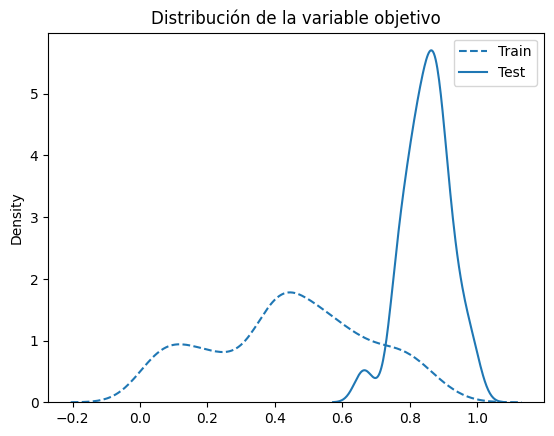

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.kdeplot(y_train, label="Train", linestyle="--")
sns.kdeplot(y_test, label="Test")
plt.legend()
plt.title("Distribución de la variable objetivo")
plt.show()


La distribución de la variable objetivo difiere entre los conjuntos de entrenamiento y prueba, observándose una mayor concentración de valores altos en el conjunto de prueba. Este comportamiento es consistente con un particionamiento temporal, donde los datos más recientes reflejan niveles de producción superiores a los históricos. Lejos de representar un problema, esta diferencia introduce un escenario de evaluación más realista y evita el sesgo optimista que produciría un particionamiento aleatorio.

### <a class="anchor" id="baseline">3. Modelo baseline y evaluación de métricas</a>



#### Regresión Lineal

Como primer paso para la construcción de un modelo baseline, se decidió crear un modelo de regresión lineal. Si bien, el dataset original estaba construido como una serie de tiempo, la información de la fecha fue desagregada y procesada para incluirse como variables independientes para el dataset, de esta forma se vuelve factible el uso de este dataset para el entrenamiento del modelo. El propósito de entrenar un modelo de regresión lineal es identificar si es viable entrenar un modelo que ignore el contexto histórico y realice predicciones confiables como si los datos fueran independientes entre sí, esto porque el modelo de regresión lineal no trabaja con series de tiempo. Este modelo serviría para confirmar o rechazar la relevancia que existe entre la dependencia temporal de los datos.

Este modelo es apropiado también por razones adicionales como el hecho de que el dataset está compuesto por datos estructurados, y el modelo trabaja únicamente con datos estructurados. Igualmente el tamaño del dataset es relativamente pequeño, teniendo 439 registros en total para el conjunto de entrenamiento, por lo que puede trabajarse perfectamente con librerías como `Scikit-Learn` que no utilizan ninguna especie de particionamiento. Por último, la interpretabilidad del modelo es sencilla ya que directamente realiza predicciones empleando las unidades de la variable de salida, que para este caso es volumen de producción de aguacate.

In [23]:
# Creación de la instancia del modelo de Regresión Lineal
LR_model = LinearRegression()

# Entrenamiento del modelo
LR_model = LR_model.fit(X_train, y_train)

# Realización de predicciones sobre el conjunto de prueba
LR_model_result = LR_model.predict(X_test)

# Obtención de métricas de desempeño
print("RMSE: ", root_mean_squared_error(y_test, LR_model_result))
print("R2: ", r2_score(y_test, LR_model_result))
print("MAE: ", mean_absolute_error(y_test, LR_model_result))
print("MAPE: ", mean_absolute_percentage_error(y_test, LR_model_result))

RMSE:  0.10585271820325111
R2:  -1.3275749196415636
MAE:  0.09214261218184501
MAPE:  0.10858603477378284


####Regresión Ridge

En caso de que exista sobreaprendizaje, se puede emplear otro modelo de regresión para nuevamente evaluar la posibilidad de ignorar el contexto histórico del dataset. En esta ocasión se entrenará el modelo de regresión Ridge, que también trae consigo una gran ventaja que puede ser de ayuda por la estructura del dataset, y es que se tienen variables con alta correlación como `Sembrada` y `Cosechada` como se encontró en etapas anteriores del proyecto pero que se decidieron mantener por su interpretabilidad agronómica, y este modelo puede ser de ayuda ya que maneja adecuadamente la multicolinealidad gracias a que emplea la regularización L2.

Nuevamente, la consistencia estructurada de los datos y la poca cantidad de registros hace al dataset compatible con el modelo de regresión Ridge disponible en la librería de `Scikit-Learn`.

In [56]:
# Creación de la instancia del modelo de Regresión Ridge
Ridge_model = Ridge(alpha=1.5)

# Entrenamiento del modelo
Ridge_model = Ridge_model.fit(X_train, y_train)

# Realización de predicciones sobre el conjunto de prueba
Ridge_model_result = Ridge_model.predict(X_test)

# Obtención de métricas de desempeño
print("RMSE: ", root_mean_squared_error(y_test, Ridge_model_result))
print("R2: ", r2_score(y_test, Ridge_model_result))
print("MAE: ", mean_absolute_error(y_test, Ridge_model_result))
print("MAPE: ", mean_absolute_percentage_error(y_test, Ridge_model_result))

RMSE:  0.1039563036311609
R2:  -1.2449222126091826
MAE:  0.09065306820777791
MAPE:  0.10667062942459811


####Regresión Lasso

Nuevamente fue seleccionado otro modelo de regresión que logra reducir el sobreajuste, la regresión Lasso. Este modelo, aparte de nuevamente evaluar la viabilidad de ignorar el contexto histórico, este es de utilidad para la selección de variables, y es que como este modelo emplea la regularización L1, con ello las variables que no compensen la penalización sus coeficientes se volverán 0. Lo cual para este caso puede ser de utilidad ya que, por el tamaño reducido del dataset, ninguna de las variables que fueron empíricamente seleccionadas fueron eliminadas, por lo que el modelo puede tener la facultad de determinar si realmente existen algunas variables que no aporten significativamente a la predicción.

De la misma forma, la consistencia estructurada de los datos y la poca cantidad de registros hace al dataset compatible con el modelo de regresión Lasso disponible en la librería de `Scikit-Learn`.

In [75]:
# Creación de la instancia del modelo de Regresión Lasso
Lasso_model = Lasso(alpha=0.0001, max_iter=150)

# Entrenamiento del modelo
Lasso_model = Lasso_model.fit(X_train, y_train)

# Realización de predicciones sobre el conjunto de prueba
Lasso_model_result = Lasso_model.predict(X_test)

# Obtención de métricas de desempeño
print("RMSE: ", root_mean_squared_error(y_test, Lasso_model_result))
print("R2: ", r2_score(y_test, Lasso_model_result))
print("MAE: ", mean_absolute_error(y_test, Lasso_model_result))
print("MAPE: ", mean_absolute_percentage_error(y_test, Lasso_model_result))

RMSE:  0.1035151381695796
R2:  -1.225908826441541
MAE:  0.0899816933144876
MAPE:  0.10601866941334778


#### Naive

Caso contrario a todos los modelos realizados previamente, ahora se contemplarán modelos que puedan emplear el contexto histórico de los datos para confirmar o rechazar la dependencia temporal de los datos. Por ello, se decidió entrenar un modelo Naive, el cual justamente trabaja con datasets que son series de tiempo, por eso mismo, de todos los modelos entrenados hasta este momento, el modelo Naive es el más prometedor para ser usado como nuestro modelo baseline, además de que se espera un mejor rendimiento que del resto de modelos.

De todos los modelos que se emplean para series de tiempo, se escogió el modelo Naive porque es el modelo más simple, por lo que sería un buen modelo baseline que en el caso de que diera buenos resultados, perfectamente podría ser usado para construir modelos alternativos más complejos y comparar su rendimiento contra el modelo más simple para identificar de la forma más clara posible si hay avances significativos o si la complejidad en los modelos es innecesaria.

El modelo Naive es un modelo simple porque realmente no aprende parámetros, por lo que no requiere un entrenamiento real, pero su comportamiento es como matemáticamente se describe un random walk, es decir que el valor actual es el valor del pasado más un valor aleatorio, solo se usa el último valor para realizar la predicción, lo que lo vuelve un modelo útil para ser empleado como baseline.

Para la implementación de este algoritmo, se hará uso de la librería `statsmodels` empleando el modelo `ARIMA` pero con una configuración particular: se eliminan los componentes de la parte autorregresiva y la del promedio móvil, dejando únicamente la parte de la diferenciación en 1, lo que emula el comportamiento del modelo Naive. Nuevamente, la consistencia estructurada de los datos y la poca cantidad de registros hace al dataset compatible con esta librería y modelo seleccionados.

In [77]:
# Creación de la instancia del modelo Naive
Naive_model = ARIMA(y_train, order = (0, 1, 0))

# Entrenamiento del modelo
Naive_model = Naive_model.fit()

# Realización de predicciones sobre el conjunto de prueba
Naive_model_result = Naive_model.forecast(steps = len(X_test))

# Obtención de métricas de desempeño
print("RMSE: ", root_mean_squared_error(y_test, Naive_model_result))
print("R2: ", r2_score(y_test, Naive_model_result))
print("MAE: ", mean_absolute_error(y_test, Naive_model_result))
print("MAPE: ", mean_absolute_percentage_error(y_test, Naive_model_result))

RMSE:  0.08646029501913467
R2:  -0.5528627258597016
MAE:  0.07082112962857938
MAPE:  0.08117407436108368


### <a class="anchor" id="interpretacion">4. Intepretación y comparación</a>



**¿Qué algoritmo se puede utilizar como baseline para predecir las variables objetivo?**

A partir de los resultados obtenidos, se puede observar que el modelo Naive, el cual como ya fue mencionado funciona para series de tiempo, ya que utiliza como predicción para el siguiente periodo el último valor observado en la serie, presenta el mejor desempeño entre los modelos evaluados.

En sus métricas se puede observar que el RMSE fue de 0.086, lo que indica que, en comparación con los otros modelos, mantiene una medida de error más pequeña. Con respecto al MAE, que fue de 0.070, se observa igualmente un valor menor en comparación con los demás modelos, lo que indica que en promedio se equivoca menos.

La diferencia entre RMSE y MAE no es considerablemente grande, lo que sugiere que no se están presentando errores extremadamente altos que estén afectando de manera significativa el desempeño del modelo.

En cuanto al MAPE, que fue de 0.081, esto refleja que el modelo se equivoca aproximadamente un 8% en promedio respecto a los valores reales, mientras que los otros modelos presentan un porcentaje mayor, lo que confirma nuevamente un mejor desempeño del modelo Naive.

Por otro lado, el coeficiente de determinación R² obtuvo un valor de -0.552. Aunque este valor es negativo, no se considera determinante en este caso, ya que esta métrica mide la variabilidad global explicada respecto al promedio, y en problemas de series de tiempo con tendencia creciente puede verse afectada por los cambios estructurales entre el conjunto de entrenamiento y prueba.

Aunque se evaluaron modelos de regresión lineal, regresión Ridge y regresión Lasso con el objetivo de tener una perspectiva más clara del problema, estos mostraron un desempeño inferior, presentando valores de R² negativos en los tres casos y errores más elevados en las demás métricas en comparación con el modelo Naive.
Lo anterior deja en evidencia que dichos modelos no son los más adecuados para capturar correctamente la dinámica del volumen de producción.

Por lo tanto, el modelo Naive funciona adecuadamente como modelo baseline, ya que permite capturar la estructura temporal básica del dataset y sirve como punto de referencia para evaluar modelos más complejos en futuras etapas del proyecto.


**2. ¿Se puede determinar la importancia de las características? Recuerden que incluir características irrelevantes puede afectar negativamente el rendimiento del modelo y aumentar la complejidad sin beneficios sustanciales.**


El conjunto de características utilizado para la construcción del modelo baseline forman parte del avance anterior, en la fase de análisis exploratorio de datos y de ingeniería de características. En dicha etapa se realizó un análisis sistemático de la relevancia de las variables mediante métodos de selección de tipo filter (varianza y correlación) y técnicas de extracción de características (PCA).

Como primer lugar, se aplicó un criterio de varianza para identificar variables con varianza nula o cercana a cero, debido a que no aportarían información relevante al modelo, obteniendo como resultado que ninguna de las variables presentaba este problema. Posteriormente, se realizó un análisis de correlación como método filter para detectar posibles relaciones lineales fuertes entre las variables. Se identificó una alta correlación entre las variables Sembrada y Cosechada, lo cual es esperable debido a su relación productiva directa. No obstante, ambas variables se conservaron en el conjunto de características debido a su alta interpretabilidad agronómica y a que podrían capturar dinámicas diferenciadas en modelos no lineales o en enfoques de series de tiempo multivariadas. El resto de las variables no presentó correlaciones significativas entre sí, lo que reduce el riesgo de redundancia en el espacio de características. 

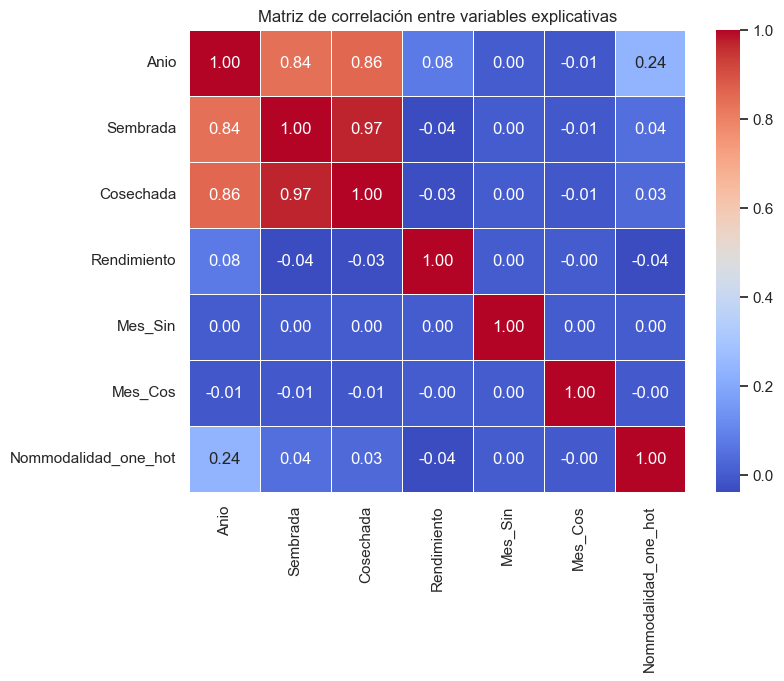



Adicionalmente, se evaluó de forma exploratoria la posibilidad de reducción de dimensionalidad mediante Análisis de Componentes Principales (PCA) como técnica de extracción de características. Sin embargo, debido al objetivo de mantener interpretabilidad y considerando que el número de variables no es muy alto, se decidió no sustituir las variables originales por componentes principales en esta etapa.

Por otro lado, el modelo baseline seleccionado Naive, el cual utiliza únicamente valores pasados de la propia serie temporal de la variable objetivo, esto es que el modelo no considera variables fuera de la variable objetivo, por lo que no es posible realizar un análisis directo de importancia de características a nivel del modelo.


No obstante, el análisis previo de relevancia de variables roporciona una base sólida para la incorporación futura de las demás variables en modelos más complejos donde la evaluación de la importancia de las características podrá realizarse mediante métodos como embedded o wrapper.

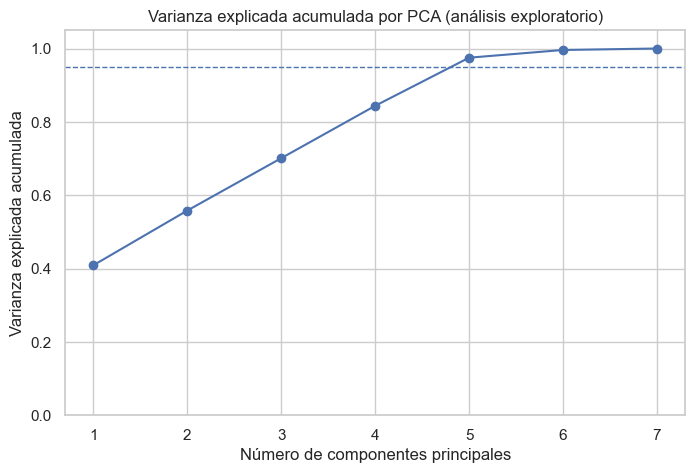

**¿El modelo está subajustando o sobreajustando?**

Dado que el modelo baseline seleccionado se basa únicamente en la variable objetivo para generar las predicciones y no incorpora variables adicionales ni hiperparámetros complejos, el riesgo de sobreajuste es bajo. Este tipo de modelo no aprende patrones complejos de los datos, por lo que tiende naturalmente al subajuste.

Para evaluar la presencia de subajuste o sobreajuste, se compararon las métricas de desempeño entre los conjuntos de entrenamiento y prueba. Los resultados muestran errores de magnitud similar en ambos conjuntos, lo que indica que no existe un sobreajuste evidente. Sin embargo, el valor negativo de R2 en el conjunto de prueba sugiere que el modelo no logra generalizar adecuadamente ni capturar la tendencia de los datos.

En consecuencia, se concluye que el modelo presenta una mayor tendencia al subajuste.

In [ ]:
y_test_series = y_test.squeeze()   
naive_pred_test = pd.Series(
    Naive_model_result,
    index=y_test_series.index
)

residuals_test = y_test_series - naive_pred_test
plt.figure(figsize=(10,4))
plt.plot(residuals_test)
plt.axhline(0, linestyle="--")
plt.title("Residuos del modelo Naive - con conjunto Prueba")
plt.xlabel("Tiempo")
plt.ylabel("Residuo")
plt.show()

El gráfico de residuos del conjunto de prueba muestra patrones temporales claros y una ausencia de aleatoriedad, con predominio de residuos positivos y variaciones en su amplitud. Esto indica que el modelo Naive no logra capturar adecuadamente la dinámica de la serie temporal. Dicho comportamiento confirma que el modelo resulta insuficiente para una predicción precisa, por lo que cumple con su uso de modelo baseline.

## <a class="anchor" id="conclusiones">Conclusiones</a>

Como trabajo futuro, se planea utilizar modelos que trabajen con series de tiempo y que sean más robustos, como por ejemplo ARIMA y SARIMA. Igualmente, para mejorar la calidad en el entrenamiento de modelos de series temporales se planea eliminar las variables que contienen información desagregada de las fechas, como `Anio`, `Mes_Sin` y `Mes_Cos`, y agregar la información de la fecha a los índices del dataset en formato 'timestamp' para que se puedan hacer interpretaciones más sencillas con respecto al tiempo. Igualmente, se planea reconsiderar la posibilidad de eliminar la variable categórica `Nommodalidad_one_hot` debido a que, con base en nueva investigación realizada, puede no contener información significativa si no se complementa con información adicional sobre el clima.

## <a class="anchor" id="ref">Referencias</a>

* Regresión lineal con Scikit-Learn: una guía completa. (2024, 13 febrero). LEARN STATISTICS EASILY. https://es.statisticseasily.com/regresi%C3%B3n-lineal-con-scikit-learn/

* Regresión Ridge (Scikit-learn). (2025, 13 septiembre). CDS Institute. https://datasciencepythonblog.net/regresion-ridge-scikit-learn/

* Lasso (Scikit-learn). (2025, 13 septiembre). CDS Institute. https://datasciencepythonblog.net/lasso-scikit-learn/

* Naïve forecasting. (s. f.). https://help.llama.ai/release/platform/doc-center/demand_topics/dem_modeler_engine_algorithms_classic_naive.htm

* How to interpret ARIMA(0,1,0). (2017, 27 octubre). Cross Validated. https://stats.stackexchange.com/questions/310353/how-to-interpret-arima0-1-0

* ARIMA forecast with python statsmodels. (s. f.). Stack Overflow. https://stackoverflow.com/questions/66651360/arima-forecast-gives-different-results-with-new-python-statsmodels